### This notebook trains an EfficientNet B5 model with smooth L1 loss on the combined and balanced dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *

import cv2

from efficientnet_pytorch import EfficientNet

from sklearn.metrics import cohen_kappa_score
import scipy as sp

In [3]:
def get_data(res=224,bs=16):
    np.random.seed(420)
    df = pd.read_csv('../Data/CombinedBalanced2.csv')
    df.diagnosis = df.diagnosis.apply(lambda x: -4 if x==0 else -2 if x==1 else 0 if x==2 else 2 if x==3 else 4)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.1)],[]]
#     tfms[0].extend(rand_resize_crop(res,max_scale=2,p=0.2))
    
    data = (ImageList.from_df(df,'')
        .split_by_rand_pct(0.2) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=res,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=os.cpu_count())).normalize(imagenet_stats)  
    return data
       

In [4]:
data = get_data()
# data.show_batch()

In [21]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >=coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        y = y.clone().cpu().apply_(lambda x: 0 if x==-4 else 1 if x==-2 else 2 if x==0 else 3 if x==2 else 4)
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [-3.0,-1.0,1.0,3.0]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

opt = OptimizedRounder()

In [4]:
class SmoothL1Flat(nn.Module):
    def __init__(self,reduction='mean'):
        super().__init__() 
        self.reduction = reduction

    def forward(self, inputs, targets):
        loss = nn.SmoothL1Loss(reduction=self.reduction)(inputs.squeeze(),targets.squeeze())
        return loss

In [9]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
def splitfunc(model):
    return [*model[0:2],model[2],model[3:5],model[5]]

# model = nn.Sequential(*children(EfficientNet.from_pretrained('efficientnet-b5', num_classes=1)))
# model = EfficientNetB4(pretrained=True)
model = EfficientNet.from_pretrained('efficientnet-b5',num_classes=1).cuda()
learn = Learner(get_data(256,48),
                 model,
                 wd=1e-5,
                 callback_fns=[ShowGraph,
#                                OverSamplingCallback,
                              partial(SaveModelCallback, every='epoch',name='fin_epoch'),
                              partial(SaveModelCallback, every='improvement', monitor='valid_loss', name='fin_best_mse'),],
#                               partial(AccumulateScheduler, n_step=2)],
                 path = '../Data/train_processed',
                 metrics=[qk,
                         mean_squared_error],
                 loss_func = SmoothL1Flat()
                )

learn.split( lambda m: (model._conv_head,) )
learn.load('fin_epoch_10')
learn.to_fp16()
print(len(learn.layer_groups))
pass

Loaded pretrained weights for efficientnet-b5
2


In [10]:
learn.validate()

[0.5665843, tensor(0.7927), tensor(2.1151)]

In [18]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 257, 257]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 128, 128]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 130, 130]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 128, 128]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 128, 128]       0          False     
_________________________________________________

In [8]:
gc.collect()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 4.79E-03


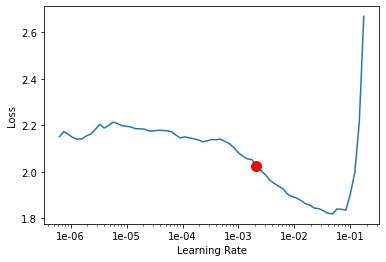

In [9]:
learn.recorder.plot(suggestion=True)

In [8]:
learn.export()

In [12]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B5', res=224, bs=16, div=25,pct=0.3):
#     learner.data = get_data(size=res,bs=bs)
#     learner.to_fp16()
#     learner.mixup(stack_y=False)
    learner.fit_one_cycle(epochs, lr, pct_start=pct, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.620000,0.617259,0.770828,2.246855,07:11
1,0.713775,1.076239,0.635828,4.545823,07:09
2,0.699050,0.797710,0.692204,2.808758,07:10
3,0.651786,0.693996,0.744872,2.649314,07:09
4,0.597443,0.637009,0.759230,2.348546,07:08
5,0.553947,0.615505,0.770461,2.178024,07:08
6,0.540427,0.689418,0.777372,2.480757,07:09


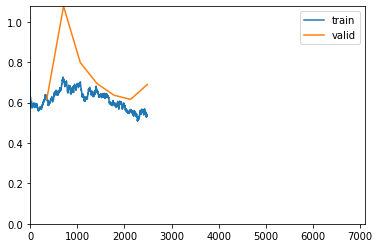

Better model found at epoch 0 with valid_loss value: 0.6172587275505066.
Better model found at epoch 5 with valid_loss value: 0.6155053377151489.


Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:off

KeyboardInterrupt: 

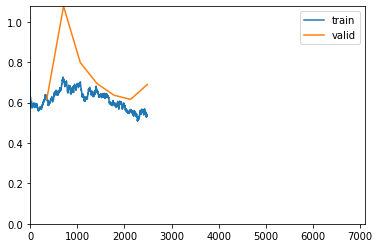

In [7]:
do_fit(learn, 20, slice(1e-3,3e-3),pct=0.1)

Loaded fin_epoch_6
Model fin_best_mse_6 not found.


epoch,train_loss,valid_loss,qk,mean_squared_error,time
7,0.526366,0.660689,0.775378,2.325923,07:09
8,0.526310,0.576264,0.789661,1.935649,07:09
9,0.459091,0.576527,0.777645,2.018836,07:12


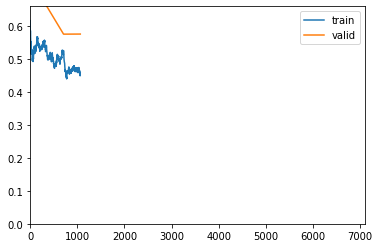

Better model found at epoch 7 with valid_loss value: 0.6606885194778442.
Better model found at epoch 8 with valid_loss value: 0.5762636661529541.


In [ ]:
do_fit(learn, 20, slice(1e-3,3e-3),pct=0.1,start_epoch=7)

Loaded fin_epoch_10
Model fin_best_mse_10 not found.


epoch,train_loss,valid_loss,qk,mean_squared_error,time
11,0.396678,0.588481,0.790983,1.967362,07:09
12,0.360478,0.544429,0.800687,1.850607,07:08
13,0.309067,0.542984,0.801528,1.908974,07:08
14,0.299869,0.542175,0.800520,1.885483,07:08
15,0.262433,0.534664,0.801876,1.850667,07:08
16,0.255525,0.537735,0.807128,1.837408,07:07
17,0.251756,0.541246,0.806953,1.860076,07:07
18,0.210114,0.539597,0.803168,1.857606,07:07
19,0.222035,0.538876,0.805682,1.858112,07:08


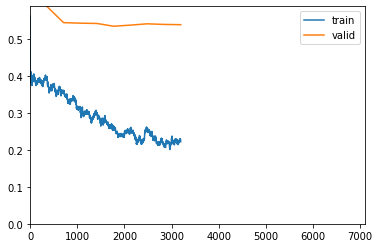

Better model found at epoch 11 with valid_loss value: 0.5884808301925659.
Better model found at epoch 12 with valid_loss value: 0.5444290637969971.
Better model found at epoch 13 with valid_loss value: 0.5429838299751282.
Better model found at epoch 14 with valid_loss value: 0.5421752333641052.
Better model found at epoch 15 with valid_loss value: 0.5346636176109314.
Model saved as B5_224_31


In [13]:
do_fit(learn, 20, slice(1e-3,3e-3),pct=0.1,start_epoch=11)

In [17]:
learn.loss_func = MSELossFlat()
learn.to_fp32()
learn.export()

In [18]:
learn.load('habib_l2_comb')
learn.to_fp32()
learn.export()

epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.739803,0.664977,0.639857,0.664977,10:01
1,0.645766,0.644183,0.710962,0.644183,09:56
2,0.629978,0.644824,0.725438,0.644824,09:58
3,0.603570,1.137956,0.575403,1.137956,09:57
4,0.543221,0.605651,0.715959,0.605650,09:56
5,0.533063,0.613503,0.722877,0.613503,09:56
6,0.435764,0.518024,0.775861,0.518024,09:56
7,0.417265,0.504003,0.777805,0.504003,09:55
8,0.355773,0.512219,0.774244,0.512219,09:56
9,0.278719,0.445098,0.792200,0.445098,09:56


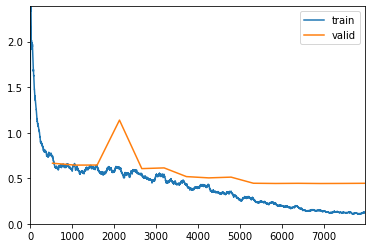

Better model found at epoch 0 with mean_squared_error value: 0.6649774312973022.
Better model found at epoch 3 with mean_squared_error value: 1.1379560232162476.
Model saved as B5_224_15


In [8]:
do_fit(learn, 20, slice(1e-3,3e-3))

epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.943765,0.876070,0.667503,2.941679,07:14
1,0.796847,0.766955,0.708884,2.711580,07:04
2,0.785713,0.951509,0.719663,3.640080,07:03
3,0.775421,0.793031,0.736153,3.024484,07:02
4,0.772588,0.846136,0.646380,3.391233,07:02
5,0.731469,0.705890,0.738174,2.638453,07:02
6,0.691952,0.697709,0.760398,2.454269,07:02
7,0.657137,0.727407,0.725770,2.699538,07:02
8,0.627619,0.752335,0.732678,2.740731,07:01
9,0.601182,0.701523,0.771330,2.631278,07:03


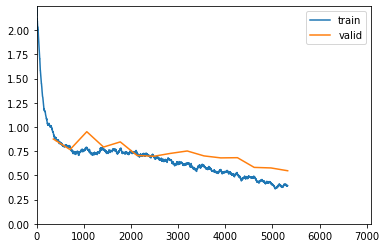

Better model found at epoch 0 with valid_loss value: 0.8760698437690735.
Better model found at epoch 1 with valid_loss value: 0.7669554352760315.
Better model found at epoch 5 with valid_loss value: 0.7058902382850647.
Better model found at epoch 6 with valid_loss value: 0.697708785533905.
Better model found at epoch 10 with valid_loss value: 0.6809529662132263.
Better model found at epoch 12 with valid_loss value: 0.5827304124832153.
Better model found at epoch 13 with valid_loss value: 0.5771483182907104.
Better model found at epoch 14 with valid_loss value: 0.5481550693511963.


In [ ]:
do_fit(learn, 20, slice(1e-3,3e-3))

Loaded fin_epoch_14
Model fin_best_mse_14 not found.


epoch,train_loss,valid_loss,qk,mean_squared_error,time
15,0.328541,0.549673,0.802972,1.897810,07:02
16,0.308839,0.545798,0.797449,1.924694,07:01
17,0.300195,0.547229,0.801478,1.914916,07:01
18,0.289109,0.544683,0.804063,1.898683,07:01
19,0.286002,0.544679,0.802963,1.896235,07:02


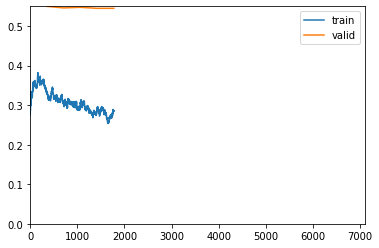

Better model found at epoch 15 with valid_loss value: 0.5496731400489807.
Better model found at epoch 16 with valid_loss value: 0.5457981824874878.
Better model found at epoch 18 with valid_loss value: 0.5446825623512268.
Better model found at epoch 19 with valid_loss value: 0.5446794629096985.
Model saved as B5_224_35


In [11]:
do_fit(learn, 20, slice(1e-3,3e-3),start_epoch=15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


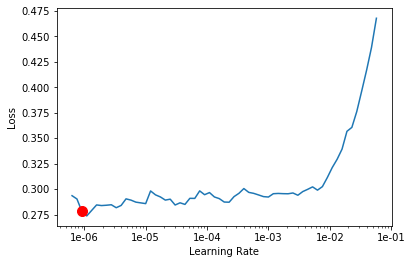

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.256654,0.545320,0.803308,1.896759,07:02
1,0.275236,0.546176,0.803501,1.901488,07:03
2,0.277269,0.545238,0.803085,1.896207,07:04
3,0.285383,0.545475,0.803439,1.895606,07:03
4,0.280505,0.545339,0.803648,1.897862,07:03


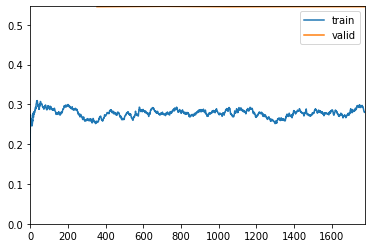

Better model found at epoch 0 with valid_loss value: 0.5453200936317444.
Better model found at epoch 2 with valid_loss value: 0.5452380180358887.
Model saved as B5_224_5


In [13]:
do_fit(learn,5,slice(1.1e-7,4e-7))

In [ ]:
learn.show_results()

In [3]:
def get_data(res=224,bs=16):
    np.random.seed(420)
    df = pd.read_csv('../Data/train_labels.csv')
    df.diagnosis = df.diagnosis.apply(lambda x: -4 if x==0 else -2 if x==1 else 0 if x==2 else 2 if x==3 else 4)
    
    tfms = [[rotate(degrees=(-5,5),p=0.1),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.1)],[]]
#     tfms[0].extend(rand_resize_crop(res,max_scale=2,p=0.2))
    
    data = (ImageList.from_df(df,'../Data/train_processed')
        .split_by_rand_pct(0.2) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=res,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=os.cpu_count())).normalize(imagenet_stats)  
    return data

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,qk,mean_squared_error,time


epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.360084,0.178656,0.952754,0.503323,01:17
1,0.340223,0.213571,0.948835,0.603538,01:15
2,0.334604,0.241180,0.937399,0.686642,01:14
3,0.322689,0.256763,0.934033,0.739273,01:15
4,0.314163,0.265901,0.930388,0.769852,01:15
5,0.309912,0.271930,0.933624,0.789921,01:15
6,0.312121,0.275230,0.932276,0.800275,01:15
7,0.307807,0.273484,0.932224,0.796450,01:15
8,0.295681,0.274941,0.931752,0.800885,01:15
9,0.312148,0.276657,0.932386,0.806212,01:15


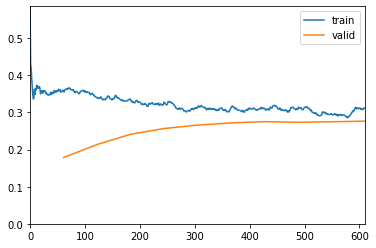

Better model found at epoch 0 with valid_loss value: 0.17865626513957977.
Model saved as B5_224_10


In [10]:
do_fit(learn, 10, (1e-6,5e-6),pct=0.1)

In [12]:
learn.load('fin_epoch_8')
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,4.0,-2.0,-4.0,-4.0
Path: ../Data/train_processed;

Valid: LabelList (732 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: ../Data/train_processed;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )

In [13]:
learn.loss_func = MSELossFlat()

In [14]:
learn.export()

epoch,train_loss,valid_loss,qk,mean_squared_error,time
0,0.220996,0.112991,0.956276,0.112991,01:44
1,0.197963,0.126277,0.949380,0.126277,01:44
2,0.171086,0.124990,0.951750,0.124990,01:44
3,0.158186,0.121621,0.955429,0.121621,01:43
4,0.156748,0.118537,0.956605,0.118537,01:44
5,0.145662,0.116470,0.957066,0.116470,01:44
6,0.141373,0.115664,0.956340,0.115664,01:44
7,0.138480,0.115593,0.956834,0.115593,01:44
8,0.139877,0.115469,0.957290,0.115469,01:43
9,0.126961,0.115601,0.956459,0.115601,01:44


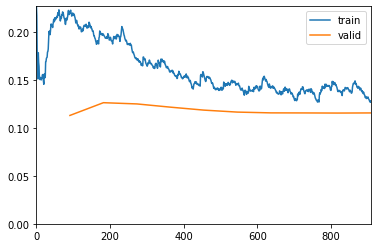

Better model found at epoch 0 with valid_loss value: 0.11299071460962296.
Model saved as B5_224_10


In [26]:
do_fit(learn, 10, 5e-6)

Model epoch_0 not found.
Model best_mse_0 not found.


epoch,train_loss,valid_loss,float_kappa_score,mean_squared_error,time
1,0.574610,0.370698,0.804756,0.023180,37:47
2,0.408552,0.325932,0.826040,0.020384,37:57


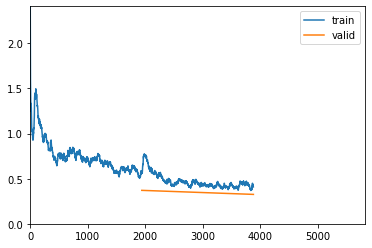

Better model found at epoch 1 with mean_squared_error value: 0.02317959815263748.
Model saved as B5_Comb_224_4


In [10]:
do_fit(learn, 3, 1e-3, start_epoch=1)

In [ ]:
learn.load('epoch_1')

In [12]:
learn.validate()

[0.5800286, tensor(0.8122), tensor(0.0363)]

In [33]:
learn.validate()

[20.541265, tensor(0.3412), tensor(1.2895)]

In [24]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)

In [13]:
y

tensor([ 2., -4., -4.,  ...,  0., -2., -4.])

In [22]:
opt = OptimizedRounder()
opt.fit(preds,y)
opt.coef_

0.8190263780355207


 final_simplex: (array([[-2.534213, -1.199005,  0.76151 ,  2.696313],
       [-2.534228, -1.199017,  0.761466,  2.696401],
       [-2.534205, -1.198998,  0.761493,  2.696353],
       [-2.5342  , -1.199011,  0.761483,  2.696361],
       [-2.534231, -1.199009,  0.761469,  2.696366]]), array([-0.819026, -0.819026, -0.819026, -0.819026, -0.819026]))
           fun: -0.8190263780355207
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 46
        status: 0
       success: True
             x: array([-2.534213, -1.199005,  0.76151 ,  2.696313])

In [23]:
learn.load('fin_epoch_16')

Learner(data=ImageDataBunch;

Train: LabelList (17051 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
-4.0,-4.0,-4.0,-4.0,-4.0
Path: .;

Valid: LabelList (4262 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,-4.0,-4.0,-4.0,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.

In [25]:
opt = OptimizedRounder()
opt.fit(preds,y.clone())
opt.coef_

0.8088281094412495


 final_simplex: (array([[-3.072035, -0.976301,  1.034201,  2.888616],
       [-3.071981, -0.976308,  1.034199,  2.888653],
       [-3.071956, -0.976324,  1.034188,  2.888613],
       [-3.071951, -0.976307,  1.03419 ,  2.888661],
       [-3.071992, -0.97632 ,  1.034187,  2.888625]]), array([-0.808828, -0.808828, -0.808828, -0.808828, -0.808828]))
           fun: -0.8088281094412495
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 29
        status: 0
       success: True
             x: array([-3.072035, -0.976301,  1.034201,  2.888616])

In [16]:
opt = OptimizedRounder()
opt.fit(preds,y)
opt.coef_

0.8116152512290806


 final_simplex: (array([[0.128667, 0.272234, 0.708601, 0.914787],
       [0.128669, 0.272244, 0.708611, 0.914727],
       [0.128667, 0.272235, 0.708605, 0.914737],
       [0.128668, 0.27224 , 0.708591, 0.914747],
       [0.128668, 0.272234, 0.708615, 0.914763]]), array([-0.811615, -0.811615, -0.811615, -0.811615, -0.811615]))
           fun: -0.8116152512290806
       message: 'Optimization terminated successfully.'
          nfev: 110
           nit: 47
        status: 0
       success: True
             x: array([0.128667, 0.272234, 0.708601, 0.914787])

In [16]:
learn.loss_func = MSELossFlat()
learn.export()

In [17]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (31016 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: FloatList
0.5,1.0,0.25,0.0,1.0
Path: .;

Valid: LabelList (7754 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: FloatList
0.5,0.0,0.25,0.5,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, m

In [18]:
# learn.callbacks = None
learn.metrics = None
learn.export()

/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EfficientNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Conv2dStaticSamePadding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MBConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Identity. It won't be checked for correctness upon loading.
  "typ

In [19]:
y.unique()

tensor([0., 1., 2., 3., 4.])

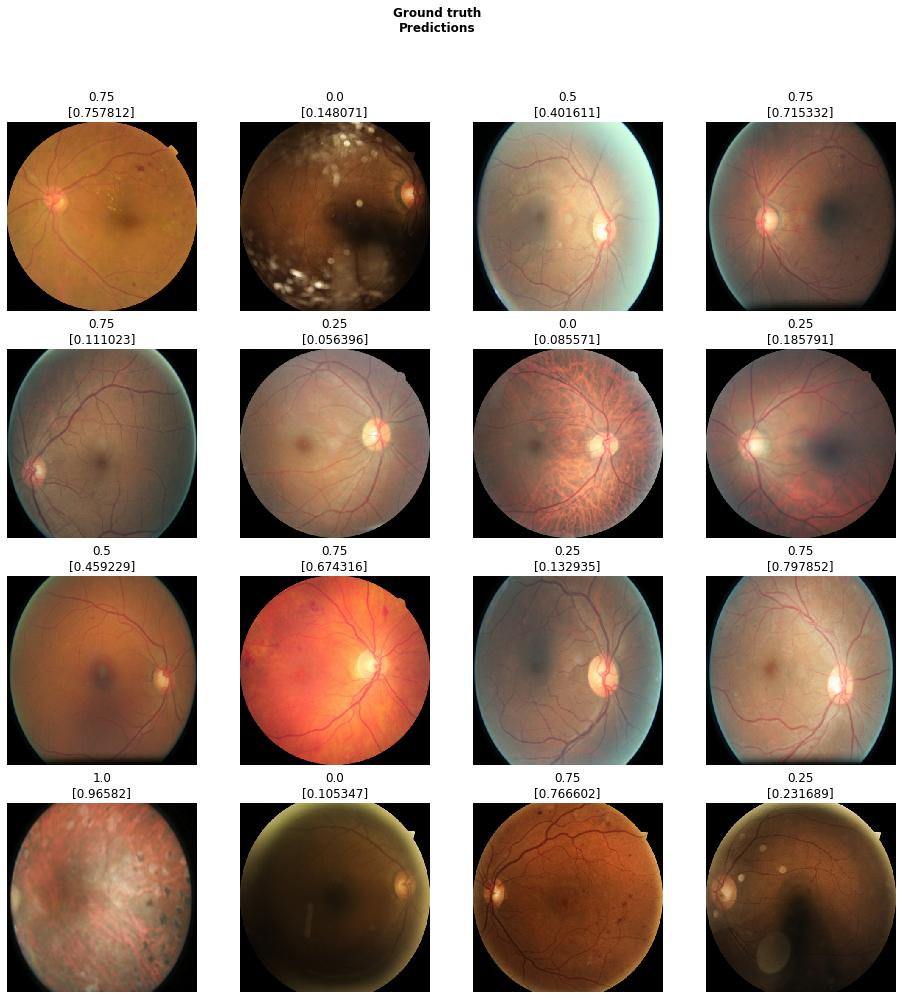

In [30]:
learn.show_results()

In [31]:
# os.mkdir('../dump/regressor')
learn.path = Path('../dump/regressor/')
learn.to_fp32()
# learn.metrics.pop(0)
learn.export()

In [14]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [15]:
!sudo shutdown -h 1

Shutdown scheduled for Wed 2019-09-04 15:05:51 UTC, use 'shutdown -c' to cancel.


In [16]:
!sudo shutdown -c

In [21]:
!mkdir ../drive/Aptos
!cp ../Data/train_processed/export.pkl ../drive/Aptos/export.pkl

In [12]:
y,preds = learn.get_preds(DatasetType.Train)

In [13]:
y1,preds1 = learn.get_preds(DatasetType.Valid)

In [23]:
y1 = y1[:,0]

In [16]:
preds1

tensor([0.5000, 0.0000, 0.2500,  ..., 0.2500, 1.0000, 1.0000])

In [17]:
preds

tensor([0.0000, 0.0000, 0.2500,  ..., 0.0000, 0.0000, 0.0000])

In [22]:
y = y[:,0]

In [32]:
Out = y.tolist()
Out.extend(y1.tolist())

In [33]:
Y = preds.tolist()
Y.append(preds1.tolist())

In [37]:
np.save('Out.npy',np.array(Out))
np.save('Y.npy',np.array(Y))

In [39]:
df = pd.read_csv('../Data/CombinedUnbalanced.csv')

In [41]:
df.groupby('diagnosis').size()

diagnosis
0    27607
1     2808
2     6287
3     1065
4     1003
dtype: int64